In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
# To allow interactive plot.
from ipywidgets import *
from IPython.display import display
from datetime import datetime, timedelta
import requests
import json
from time import sleep
import string

#import wordcloud

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#import feature extraction from nltk and sklearn
from nltk.corpus import stopwords # Import the stop word list
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from scipy.sparse import hstack,csr_matrix

from spacy.lemmatizer import Lemmatizer
import en_core_web_sm
from spacy import vocab
import regex as re

## Data Problem Statement

   **FAKE NEWS is a problem:**
   In the era of Social Media where news spread is just one click away, fake news spreads quicker and further than ever. The inability to trust news is undoubtedly a problem for people and nations as a whole. 
    
In this project we first use a labeled dataset to attempt fake news detection.

**Type A dataset: MisInfoText, Buzzfeed Dataset (2019)**
    Fatemeh Torabi Asr and Maite Taboada (2019) MisInfoText. A collection of news articles, with false and true labels. Dataset.
    
The news for this source was first taken from various Facebook groups by three Buzzfeed reporters, and were labeled with 4 classes:
    
        -Mostly True
        -Mixture of True and False
        -Mostly False
        -No Factual Content
    
The authors of this dataset then followed the URLs in the first dataset, and scraped the full text of each news article from its original source. The resulting dataset includes a total of 1380 news articles on a focused topic (US election and candidates). Veracity labels come in a four-way classification scheme including 1090 mostly true, 170 mixture of true and false, 64 mostly false and 56 articles containing no factual content.

| Type | Count |
| ------------- |:-------------:|
| **Mostly True** | 1090| 
| **Mixture of True and False** |  170 | 
| **Mostly False** |  64| 
| **No Factual Content** |  56 | 
    


## Data Cleaning 

In [2]:
columns=['id','url','rating','text','domain','source']
buzzfeed=pd.DataFrame(columns=columns)
#buzzfeed=pd.read_csv(filepath+'/Datasets/buzzfeed-v02-originalLabels.txt',sep='\t',names=columns)
buzzfeed=pd.read_csv('Datasets/buzzfeed-v02-originalLabels.txt',sep='\t',names=columns)

### Check for null data
    None. Yay!

In [3]:
buzzfeed.isnull().sum()

id        0
url       0
rating    0
text      0
domain    0
source    0
dtype: int64

In [4]:
buzzfeed.shape

(1380, 6)

In [5]:
buzzfeed.head()

,id,url,rating,text,domain,source
0,1204,http://occupydemocrats.com/2016/09/23/donald-t...,mostly true,"A few days ago, DonaldTrump despicable spawn ...",occupydemocrats.com,buzzfeed
1,1157,http://occupydemocrats.com/2016/09/19/just-50-...,mostly true,A group of over fifty former intelligence off...,occupydemocrats.com,buzzfeed
2,1165,http://occupydemocrats.com/2016/09/20/proof-tr...,mixture of true and false,A new investigation has determined that Donal...,occupydemocrats.com,buzzfeed
3,1199,http://occupydemocrats.com/2016/09/23/breaking...,mostly true,A new video has emerged of the moments before...,occupydemocrats.com,buzzfeed
4,1210,http://occupydemocrats.com/2016/09/26/wwii-vet...,mostly true,A ninety-six-year-old World War II veteran an...,occupydemocrats.com,buzzfeed


In [6]:
buzzfeed.dtypes

id         int64
url       object
rating    object
text      object
domain    object
source    object
dtype: object

### Removal of Advertisements/Disclaimers

These adverts are a result of poor scraping, but are hard to discover by hand. We search for the top n-grams to root out these occurrences.

#### Count Vectorize the raw text

**Done with 10-grams, and a mind_df of 10. Real organic phrases that long should be unlikely to appear that often**

In [7]:
X=buzzfeed['text']

In [18]:
cvec=CountVectorizer(max_df=1.0,
                     min_df=10,
                     ngram_range=(8,8),
                     token_pattern=r'\S+',
                     lowercase=True)

In [19]:
X_T=cvec.fit_transform(X)

In [20]:
X_T.shape

(1380, 185)

In [21]:
X_T=X_T.todense()

In [22]:
sumcounts=X_T[0]
for n,x in enumerate(X_T):
    if n>0:
        sumcounts=sumcounts+x

In [23]:
sumcounts

matrix([[137, 137,  17,  17,  17,  17,  17,  17,  17,  17, 137, 137,  13,
          20,  80,  12, 137, 137, 137, 137, 137, 137,  66,  18,  89,  10,
         137,  80,  80,  17,  17,  89,  10,  10,  89,  89,  66,  17,  89,
          10, 133,  17, 137,  80,  80, 137, 137,  80,  80,  10,  80,  13,
          20,  17,  17,  80,  80,  13,  13,  13, 137,  80,  20,  20,  20,
          14, 137, 137,  10,  89, 137,  80,  80, 137,  19, 137, 137, 137,
         137, 137,  80,  80,  13,  20, 137,  10,  89,  66,  13,  20,  80,
         137, 137, 137, 137,  17,  17, 137, 137,  13,  20, 137, 137, 137,
          17,  17,  80, 137, 137,  80,  10, 137,  80, 137,  66,  89,  10,
          10,  17,  80,  17, 137,  10,  89, 137,  17,  13,  20,  89,  10,
          80, 137,  80, 137, 137,  10,  17,  17,  14, 137, 137, 137,  10,
          89,  13,  20,  80,  80, 137,  10,  13,  20, 137,  10,  89,  89,
         137, 137,  10,  89,  10,  89,  13,  20, 137,  80,  66,  10, 137,
          13,  13,  13,  14,  13,  20,

**Success! Each unique count should correspond to one advert/disclaimer/structured text**

In [24]:
sumcounts=sumcounts.tolist()[0]

In [25]:
np.unique(sumcounts)

array([ 10,  12,  13,  14,  17,  18,  19,  20,  66,  80,  89, 133, 137])

**Find the first index of each 10-gram**

In [26]:
adverts=[]
for x in np.unique(sumcounts):
    adverts.append(sumcounts.index(x))

In [27]:
adverts

[25, 15, 12, 65, 2, 23, 74, 13, 22, 14, 24, 40, 0]

**The ngrams result in multiple appearances, but are demarcated by their occurrences.**


From the value counts, we can see a few main adverts:

In [28]:
ngrams=[]
for x in adverts:
    ngrams.append(cvec.get_feature_names()[x].split('. ')[0])
ngrams

['and are not not necessarily either shared or',
 "address: leave this field empty if you're human:",
 'add donald trump as an interest to stay',
 "email address: leave this field empty if you're",
 '2015 april, 2015 march, 2015 february, 2015 january,',
 'and analysis from abc news',
 'from in short, digestible chapters',
 'add elections as an interest to stay up',
 'an interest to stay up to date on',
 'add your name to millions demanding that congress',
 'and are not necessarily either shared or endorsed',
 'benefit from in short, digestible chapters',
 '101 things all young adults should know by']

**Find the full form of each advert**

In [29]:
buzzfeed['lower text']=buzzfeed['text'].apply(lambda x: x.lower())

In [30]:
fullad=[]
for n in ngrams:
    x=buzzfeed[buzzfeed['lower text'].str.contains(n)]['text'].values
    
    texts = [re.split('([.?):!"]|January, 2015 )', a) for a in x]

    for text in texts:
        for a,sentence in enumerate(text):
            if sentence.lower().find(n)>-1:
                fullad.append(sentence+text[a+1])

In [31]:
fullad=np.unique(fullad)

fullad

array([" 101 Things All Young Adults Should Know by Sir John Hawkins John Hawkins's book 101 Things All Young Adults Should Know is filled with lessons that newly minted adults need in order to get the most out of life.",
       ' Add Barack Obama as an interest to stay up to date on the latest Barack Obama news, video, and analysis from ABC News.',
       ' Add Bernie Sanders as an interest to stay up to date on the latest Bernie Sanders news, video, and analysis from ABC News.',
       ' Add Donald Trump as an interest to stay up to date on the latest Donald Trump news, video, and analysis from ABC News.',
       ' Add Elections as an interest to stay up to date on the latest Elections news, video, and analysis from ABC News.',
       ' Add Green Party as an interest to stay up to date on the latest Green Party news, video, and analysis from ABC News.',
       ' Add Hillary Clinton as an interest to stay up to date on the latest Hillary Clinton news, video, and analysis from ABC News

In [32]:
#ensuring that the full ads appear as previously counted
for ad in fullad:
    print(buzzfeed['text'].str.contains(ad).sum())

137
1
1
13
20
1
7
3
2
6
1
1
1
7
1
1
80
1
137
1
10
89
1
1
1


In [33]:
for ad in fullad:
    buzzfeed['text']=buzzfeed['text'].str.replace(ad,' ')

In [34]:
buzzfeed[buzzfeed['text'].str.contains('101 Things All Young Adults')]

,id,url,rating,text,domain,source,lower text


In [36]:
buzzfeed[buzzfeed['text'].str.contains('Buy Now')]

,id,url,rating,text,domain,source,lower text
128,2001,http://rightwingnews.com/top-news/teach-freedo...,mostly true,?This Is How I Teach Freedom Of Speech? Flag S...,rightwingnews.com,buzzfeed,?this is how i teach freedom of speech? flag s...
186,2147,http://rightwingnews.com/top-news/bar-virginia...,mostly true,A Bar in Virginia Used ColinKaepernick Jersey ...,rightwingnews.com,buzzfeed,a bar in virginia used colinkaepernick jersey ...
234,2139,http://rightwingnews.com/top-news/need-know-de...,mixture of true and false,All You Need To Know About The Debate In ONE A...,rightwingnews.com,buzzfeed,all you need to know about the debate in one a...
237,2106,http://rightwingnews.com/corruption/al-sharpto...,mostly true,AlSharpton daughter sues NYC for 5 mil over an...,rightwingnews.com,buzzfeed,alsharpton daughter sues nyc for 5 mil over an...
245,1948,http://rightwingnews.com/celebrities/angelina-...,mixture of true and false,Angelina Jolie Files For DIVORCE From Brad Pit...,rightwingnews.com,buzzfeed,angelina jolie files for divorce from brad pit...
...,...,...,...,...,...,...,...
1327,2026,http://rightwingnews.com/top-news/just-in-texa...,mixture of true and false,What Texas Just Did Will Make You PROUD! ? Oba...,rightwingnews.com,buzzfeed,what texas just did will make you proud! ? oba...
1354,1975,http://rightwingnews.com/top-news/white-female...,mostly true,White Female Cop Shoots and Kills Black Suspec...,rightwingnews.com,buzzfeed,white female cop shoots and kills black suspec...
1355,2032,http://rightwingnews.com/top-news/white-guy-wa...,mostly false,White Guy Walled In Car By BlackLivesMatter Pr...,rightwingnews.com,buzzfeed,white guy walled in car by blacklivesmatter pr...
1359,2053,http://rightwingnews.com/black-lives-matter/th...,mixture of true and false,Who Do You ThinkYou Fooling BlackLivesMatter? ...,rightwingnews.com,buzzfeed,who do you thinkyou fooling blacklivesmatter? ...


In [38]:
buzzfeed['text']=buzzfeed['text'].str.replace('Buy Now','')

## Data Visualization

### Class balance (Ratings)

<BarContainer object of 4 artists>

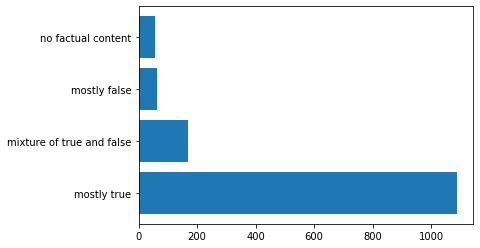

In [39]:
plt.barh(buzzfeed['rating'].value_counts().index,buzzfeed['rating'].value_counts().values)

### Top 10 Sources

<BarContainer object of 10 artists>

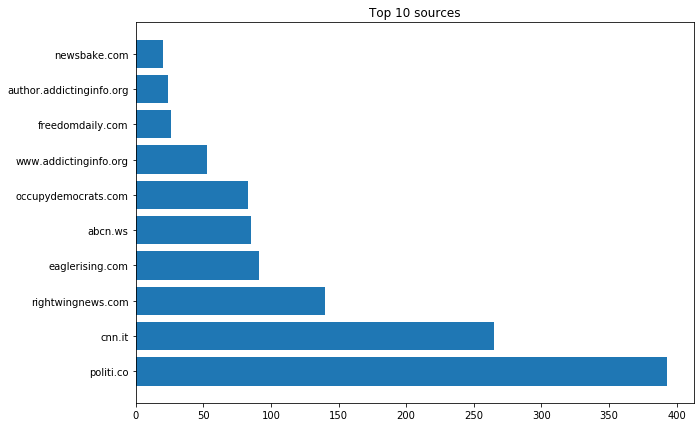

In [40]:
plt.figure(figsize=(10,7))
plt.title('Top 10 sources')
top10domains=buzzfeed['domain'].value_counts().index[0:10]
plt.barh(top10domains,buzzfeed['domain'].value_counts().values[0:10])

### Content rating for Top 10 domains

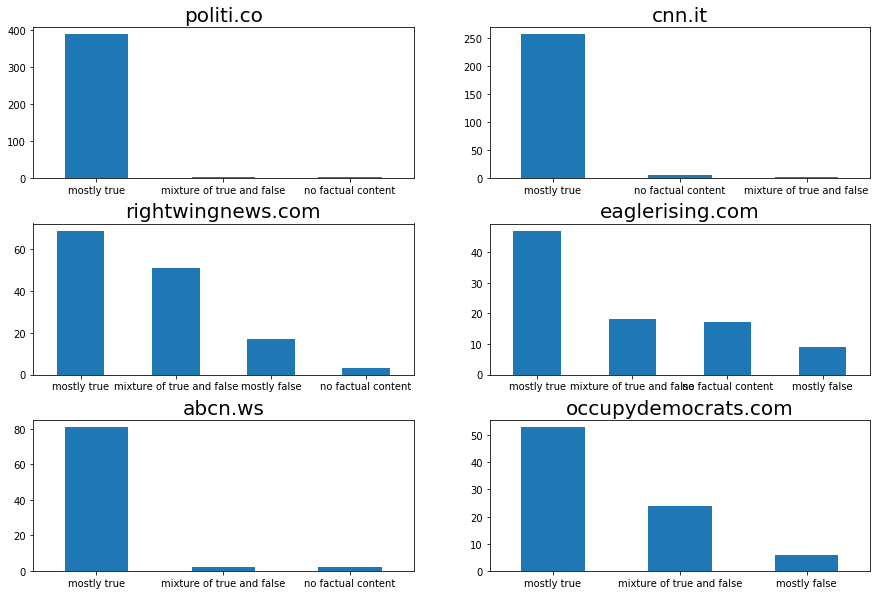

In [41]:
fig,ax = plt.subplots(nrows=3,ncols=2,figsize=(15,10),sharex=False)
ax=ax.ravel()
plt.subplots_adjust(hspace=0.3)

for x,domain in enumerate(top10domains):
    if x==6:
        break
    ax[x].set_title(domain,size=20)
    buzzfeed[buzzfeed['domain']==domain]['rating'].value_counts().plot(kind='bar',ax=ax[x])
    ax[x].tick_params(labelrotation=0)

In [42]:
mostlytrue=WordCloud(width=1080,height=720,background_color='white',stopwords=STOPWORDS,max_words=30,prefer_horizontal=True,regexp='(?u)\\b\\w\\w+\\b').generate(buzzfeed[buzzfeed['rating']=='mostly true']['text'].sum())
mixture=WordCloud(width=1080,height=720,background_color='white',stopwords=STOPWORDS,max_words=30,prefer_horizontal=True,regexp='(?u)\\b\\w\\w+\\b').generate(buzzfeed[buzzfeed['rating']=='mixture of true and false']['text'].sum())
mostlyfalse=WordCloud(width=1080,height=720,background_color='white',stopwords=STOPWORDS,max_words=30,prefer_horizontal=True,regexp='(?u)\\b\\w\\w+\\b').generate(buzzfeed[buzzfeed['rating']=='mostly false']['text'].sum())
nfc=WordCloud(width=1080,height=720,background_color='white',stopwords=STOPWORDS,max_words=30,prefer_horizontal=True,regexp='(?u)\\b\\w\\w+\\b').generate(buzzfeed[buzzfeed['rating']=='no factual content']['text'].sum())


### Word Clouds for the different Classes

    The word clouds for all four classes look pretty similiar, oweing to the fact that

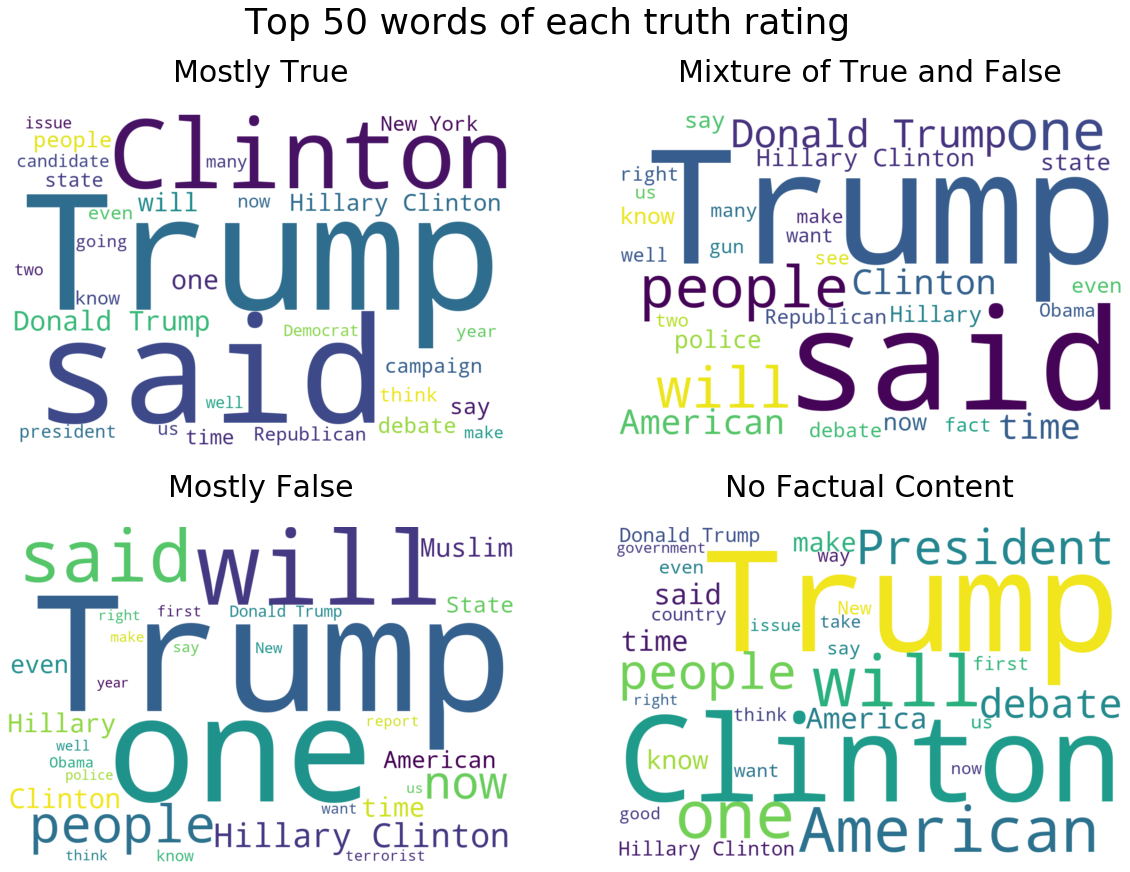

In [43]:
ncols=2
nrows=2
fig,ax=plt.subplots(ncols=ncols,nrows=2,figsize=(ncols*10,7*nrows))
ax=ax.ravel()
cloudlist=[mostlytrue,mixture,mostlyfalse,nfc]
cloudtitles=['Mostly True','Mixture of True and False','Mostly False','No Factual Content']
for n,axes in enumerate(ax):
    axes.axis("off")
    axes.imshow(cloudlist[n], interpolation='bilinear')
    axes.set_title(str(cloudtitles[n]),fontsize=30,pad=30)

fig.suptitle('Top 50 words of each truth rating',fontsize=36,)

plt.show()

## Preprocessing

    Because are only interested in detecting whether news contains false information, we turn this into a binary classification problem by classifying "Mostly true" as the negative class and all other ratings as the positive class

### Defining the target

In [44]:
buzzfeed['target']=buzzfeed['rating'].apply(lambda x: 0 if x=='mostly true' else 1)

In [45]:
buzzfeed['target'].value_counts(normalize=True)

0    0.789855
1    0.210145
Name: target, dtype: float64

### NLTK Lemmatization

In [46]:
import nltk
nltk.download('stopwords')


stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized



[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
buzzfeed['nltklemma']=buzzfeed['text'].apply(lambda x:clean(x))

### Spacy Lemmatization

In [48]:
nlp = en_core_web_sm.load()
#with full text
def spacy_lemma(doc):
    text=nlp(doc)
    newtext=[]
    for token in text:
        if not token.is_stop:
                newtext.append(token.lemma_)

    return " ".join(token for token in newtext)
#With scrubbed pronouns
def spacy_lemma2(doc):
    text=nlp(doc)
    newtext=[]
    for token in text:
        if not token.is_stop:
            if token.pos_ == 'PROPN':
                newtext.append(token.pos_)
            else:
                newtext.append(token.lemma_)

    return " ".join(token for token in newtext)

In [49]:

buzzfeed['spacylemma']=buzzfeed['text'].apply(lambda x: spacy_lemma(x))


In [50]:
buzzfeed['spacylemma2']=buzzfeed['text'].apply(lambda x: spacy_lemma2(x))

### Part of speech bag of words

In [58]:
def spacy_pos(doc):
    text=nlp(doc)
    newtext=[]
    for token in text:
        if not token.is_stop:
            newtext.append(token)

    return " ".join(token.pos_ for token in newtext)


def spacy_pos2(doc):
    text=nlp(doc)
    newtext=[]
    for token in text:
        if not token.is_punct:
            newtext.append(token)

    return " ".join(token.pos_ for token in newtext)

In [52]:
buzzfeed['spacy_pos']=buzzfeed['text'].apply(lambda x: spacy_pos(x))


In [59]:
buzzfeed['spacy_pos2']=buzzfeed['text'].apply(lambda x: spacy_pos2(x))

### Save CSV

In [63]:
buzzfeed.head(2)

,id,url,rating,text,domain,source,lower text,target,nltklemma,spacylemma,spacylemma2,spacy_pos,spacy_pos2
0,1204,http://occupydemocrats.com/2016/09/23/donald-t...,mostly true,"A few days ago, DonaldTrump despicable spawn ...",occupydemocrats.com,buzzfeed,"a few days ago, donaldtrump despicable spawn ...",0,day ago donaldtrump despicable spawn tweeted m...,"day ago , DonaldTrump despicable spawn tweet...","day ago , PROPN despicable spawn tweet meme ...",SPACE NOUN ADV PUNCT PROPN ADJ NOUN VERB NOUN ...,SPACE DET ADJ NOUN ADV PROPN ADJ NOUN VERB ADP...
1,1157,http://occupydemocrats.com/2016/09/19/just-50-...,mostly true,A group of over fifty former intelligence off...,occupydemocrats.com,buzzfeed,a group of over fifty former intelligence off...,0,group fifty former intelligence official natio...,group intelligence official national securit...,group intelligence official national securit...,SPACE NOUN NOUN NOUN ADJ NOUN NOUN VERB NOUN V...,SPACE DET NOUN ADP ADP NUM ADJ NOUN NOUN CCONJ...


In [60]:
buzzfeed.to_csv('Cleaned CSV/buzzfeedclean.csv',index=False)

In [62]:
buzzfeed=pd.read_csv('Cleaned CSV/buzzfeedclean.csv')